### Mathieu Alain  ~~ August 2019

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer.mcmc.api import MCMC
import pyro.poutine as poutine
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

from pyro.infer.mcmc.util import predictive
from pyro.distributions.util import sum_rightmost

from torch.autograd import Variable
import matplotlib.pyplot as plt

pyro.set_rng_seed(42)

In [56]:
def Generate_Data(nb_data, nb_features, autoreg_order):
    
    A, B  = np.random.uniform(0,1, nb_data), np.random.uniform(1,10, nb_data) 
    std = np.random.uniform(0,2, nb_features)
    linspace = 0.1*np.linspace(0, 50, nb_data)
    X = torch.zeros(nb_features, nb_data)
    Y = torch.zeros(nb_data)    
    for i in range(0, nb_features):
        X[i,:] = torch.tensor(A[i]*linspace*linspace + B[i] +  np.random.normal(loc=0.0, scale=std[i], size=nb_data)) 
        
    for i in range(0, nb_data):
        Y[i] = Y[i-1] - Y[i-2] + Y[i-3]
        for j in range(0, nb_features):
            Y = Y + 0.1*X[j,:]
    return X, Y

In [57]:
X, Y = Generate_Data(100,2,2)

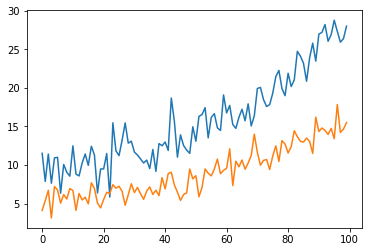

In [58]:
for i in range(0, X.shape[0]):
    plt.plot(X[i].numpy())

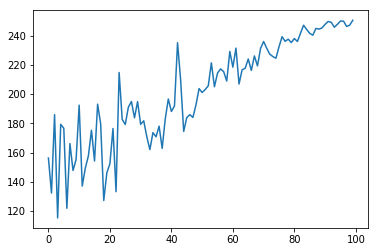

In [59]:
plt.plot(Y.numpy())

## Dataset Generation

In [47]:
N = 250 # Size of the dataset
X_data = torch.rand(N,1) # Sampling of N uniformly distributed points
a, b = 10, 2
sigma = 2 
Y_data = a * X_data + b + dist.Normal(loc=0, scale=sigma).sample([N,1]) # Computing Y_data with normal noise

In [ ]:
plt.scatter(X_data.numpy(), Y_data.numpy(), s=4)

## Neural Network Model

In [ ]:
class NNModel(nn.Module):
    
    
    def __init__(self, input_dim, output_dim):
        super(NNModel, self).__init__() 
        self.L1 = nn.Linear(input_dim, output_dim) 
        
        
    def forward(self, x):
        output = self.L1(x)
        return output

## Pyro Model

In [ ]:
def model(x):
    
    L1w_prior = dist.Normal(loc=torch.zeros_like(Net.L1.weight), scale=torch.ones_like(Net.L1.weight))
    L1b_prior = dist.Normal(loc=torch.zeros_like(Net.L1.bias), scale=torch.ones_like(Net.L1.bias))
    sigma = pyro.sample('sigma', dist.Uniform(0,2))

    priors = {'L1.weight': L1w_prior, 'L1.bias': L1b_prior, 'sigma': sigma}
    
    
    lifted_module = pyro.random_module("module", Net, priors)
    lifted_net = lifted_module()
    

    with pyro.plate("map", len(x)):
        prediction = lifted_net(x)
        pyro.sample("obs", dist.Normal(prediction, sigma))
        return prediction

In [ ]:
def conditioned_model(model, x, y):
    return poutine.condition(model, data={"obs":y})(x)

## Execution

In [ ]:
Net = NNModel(1,1)

In [ ]:
nuts_kernel = NUTS(conditioned_model)
mcmc = MCMC(nuts_kernel, num_samples=150, warmup_steps=0, num_chains=1)

In [ ]:
mcmc.run(model, X_data, Y_data)
mcmc.summary()

## Samples 

In [ ]:
samples = mcmc.get_samples()
weight = samples['module$$$L1.weight'].numpy()
weight = weight.reshape(weight.shape[0],1)
bias = samples['module$$$L1.bias'].numpy()

In [ ]:
plt.title("L1 weight according to the number of samples")
plt.plot(weight)

In [ ]:
plt.title("L1 bias according to the number of samples")
plt.xlabel('Samples')
plt.plot(bias)

In [ ]:
from pyro.infer.mcmc.util import predictive
samples = mcmc.get_samples()

In [ ]:
print(samples['sigma'].shape)
print(samples['module$$$L1.weight'].shape)
print(samples['module$$$L1.bias'].shape)

In [ ]:
samples['module$$$L1.weight'] = samples['module$$$L1.weight'].view(250,1)

In [ ]:
trace = predictive(conditioned_model, samples, model, X_data, Y_data, return_trace=True)

In [ ]:
trace.compute_log_prob()

In [ ]:
trace.nodes.keys()

In [ ]:
log_prob = trace.nodes['obs']['log_prob']

In [ ]:
plt.plot(-0.025*torch.sum(log_prob, dim=0).numpy())